In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy
from scipy.spatial.distance import cdist
from scipy.ndimage import generic_filter
# Baseline imports
from skimage import feature

import pandas

In [37]:
PATH = "./awe"
IMAGE_SIZE = [(64,64),(128, 128),(256,256)]
R = [1, 2, 3]
L = [8, 16, 32]
HIST_AREA = [16, 32, 64]
STEP = [1, 2, 4]

In [58]:
def accuracy_score(array, metric="euclidean"):
    distance_matrix = cdist(
        array, array, metric=metric)
    np.fill_diagonal(distance_matrix, np.inf)
    truth_vector = np.array(
        [i // 10 == pred // 10 for i, pred in enumerate(np.argmin(distance_matrix, 1))])
    return np.sum(truth_vector) / truth_vector.shape[0]


def make_lbp_window(r, l):
    indices = [np.around(np.array(
        (r * np.sin(2*u*np.pi/l), r * np.cos(2*u*np.pi/l)))).astype(int) for u in range(l)]

    window = np.zeros((1 + np.ptp(indices), 1 + np.ptp(indices)))
    window_center = (window.shape[0] // 2, window.shape[1] // 2)
    window[window_center] = 1
    for x in indices:
        cords = x + window_center
        window[cords[0], cords[1]] = 1
    return window

def make_histograms(array, area, image_size, bins=2**L[0]):
    for index, image in enumerate(array):
        array[index] = make_hist_for_image(image, area, image_size, bins)
    return array

def make_hist_for_image(image, area, image_size, bins):
    image = image.reshape(image_size)
    hists = []
    for row in range(0, image_size[0], area):
        for col in range(0, image_size[1], area):
            hist, _ = np.histogram(
                image[row:row+area, col:col+area].astype(int), bins=np.arange(bins + 1))
            hists.extend(hist)
    return np.array(hists)


def simple_lbp(values):
    center = np.take(values, values.size // 2)
    values = np.delete(values, values.size // 2)
    values = np.array([(value - center >= 0) * 2 **
                       index for index, value in enumerate(values)])
    return np.sum(values)


def uniform_calculation(values, center_value):
    u_1 = np.abs(int((values[-1] - center_value) >= 0) -
                 int((values[0] - center_value) >= 0))
    u_2 = np.sum(np.abs((values[1:] - center_value) >= 0).astype(int) -
                 ((values[:-1] - center_value) >= 0).astype(int))
    return (u_1 + u_2) <= 2


def uniform_lbp(values):
    center = np.take(values, values.size // 2)
    values = np.delete(values, values.size // 2)
    if uniform_calculation(values, center):
        return np.sum((values - center) >= 0)
    return L + 1


In [12]:
DATA_FRAME = pandas.DataFrame(columns=["Feature", "Unifrom", "Metric", "Result", "Skimage", "Image Size", "R", "L", "Step", "Histogram", "Histogram Tile Size"])

In [66]:
DATA_FRAME2 = pandas.DataFrame(columns=["Feature", "Unifrom", "Metric", "Result", "Skimage", "Image Size", "R", "L", "Step", "Histogram", "Histogram Tile Size"])

In [88]:
for size in IMAGE_SIZE:
    IMAGES = []
    for subfolder in os.listdir(PATH):
        sf = os.path.join(PATH, subfolder)
        if os.path.isdir(sf):
            for image in os.listdir(sf):
                image_f = os.path.join(sf, image)
                if os.path.isfile(image_f) and "json" not in image_f:
                    img = cv2.imread(
                        image_f, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, size).astype(np.float64)
                    IMAGES.append(img)
    
    for r, l in zip(R,L):
        uniform_skimage_lbp = [feature.local_binary_pattern(
            image, l, r, method="uniform").flatten() for image in copy.deepcopy(IMAGES)]
        
        lbp_footprint = make_lbp_window(r, l)

        uniform_lbp_images = [generic_filter(
                image, uniform_lbp, footprint=lbp_footprint, mode="nearest").flatten() for image in copy.deepcopy(IMAGES)]
        
        for step in STEP:
            uniform_lbp_images = uniform_lbp_images[::step]
        
            DATA_FRAME2.loc[len(DATA_FRAME2.index)] = ["LBP", True, "euclidean", accuracy_score(
                uniform_lbp_images), accuracy_score(uniform_skimage_lbp), size, r, l, step, False, None]
            DATA_FRAME2.loc[len(DATA_FRAME2.index)] = ["LBP", True, "cityblock", accuracy_score(
                uniform_lbp_images, "cityblock"), accuracy_score(uniform_skimage_lbp, "cityblock"), size, r, l, step, False, None]
            DATA_FRAME2.loc[len(DATA_FRAME2.index)] = ["LBP", True, "cosine", accuracy_score(
                uniform_lbp_images, "cosine"), accuracy_score(uniform_skimage_lbp, "cosine"), size, r, l, step, False, None]
            
            for hist_area in HIST_AREA:
                uniform_lbp_hist = make_histograms(copy.deepcopy(
                    uniform_lbp_images), hist_area, size)
                uniform_skimage_lbp_hist = make_histograms(
                    copy.deepcopy(uniform_skimage_lbp), hist_area, size)
                
                DATA_FRAME2.loc[len(DATA_FRAME2.index)] = ["LBP", True, "euclidean", accuracy_score(
                    uniform_lbp_hist), accuracy_score(uniform_skimage_lbp_hist), size, r, l, step, True, hist_area]
                DATA_FRAME2.loc[len(DATA_FRAME2.index)] = ["LBP", True, "cityblock", accuracy_score(
                    uniform_lbp_hist, "cityblock"), accuracy_score(uniform_skimage_lbp_hist, "cityblock"), size, r, l, step, True, hist_area]
                DATA_FRAME2.loc[len(DATA_FRAME2.index)] = ["LBP", True, "cosine", accuracy_score(
                    uniform_lbp_hist, "cosine"), accuracy_score(uniform_skimage_lbp_hist, "cosine"), size, r, l, step, True, hist_area]


In [93]:
DATA_FRAME2.loc[DATA_FRAME2["Step"] != 1, "Skimage"] = None

In [97]:
DATA_FRAME2.reset_index(drop=True, inplace=True)

In [90]:
DATA_FRAME.to_csv("results.csv")

In [99]:
DATA_FRAME = DATA_FRAME.append(DATA_FRAME2, ignore_index=True)


C:\Users\rjutr\AppData\Local\Temp\ipykernel_35764\3385429529.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DATA_FRAME = DATA_FRAME.append(DATA_FRAME2, ignore_index=True)


#### Debugging

In [67]:
[1,2,3,4,5,6][:2]

[1, 2]

In [18]:
PATH = "./awe"
IMAGE_SIZE = (128, 128)
R = 1
L = 8
HIST_AREA = 16
STEP = 1

IMAGES = []

In [19]:
for subfolder in os.listdir(PATH):
    sf = os.path.join(PATH, subfolder)
    if os.path.isdir(sf):
        for image in os.listdir(sf):
            image_f = os.path.join(sf, image)
            if os.path.isfile(image_f) and "json" not in image_f:
                img = cv2.imread(
                    image_f, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, IMAGE_SIZE).astype(np.float64)
                IMAGES.append(img


In [20]:
def accuracy_score(array, metric="euclidean"):
    distance_matrix = cdist(
        array, array, metric=metric)
    np.fill_diagonal(distance_matrix, np.inf)
    truth_vector = np.array(
        [i // 10 == pred // 10 for i, pred in enumerate(np.argmin(distance_matrix, 1))])
    return np.sum(truth_vector) / truth_vector.shape[0]

In [21]:
def make_histograms(array, area, image_size, bins=2**L):
    for index, image in enumerate(array):
        array[index] = make_hist_for_image(image, area, image_size, bins)
    return array

def make_hist_for_image(image, area, image_size, bins):
    image = image.reshape(image_size)
    hists = []
    for row in range(0, image_size[0], area):
        for col in range(0, image_size[1], area):
            hist, _ = np.histogram(
                image[row:row+area, col:col+area].astype(int), bins=np.arange(bins + 1))
            hists.extend(hist)
    return np.array(hists)

#### Pixel By Pixel

In [22]:
pixel_by_pixel_features = [image.flatten() for image in copy.deepcopy(IMAGES)]
print(accuracy_score(pixel_by_pixel_features))
print(accuracy_score(pixel_by_pixel_features, "cityblock"))
print(accuracy_score(pixel_by_pixel_features, "cosine"))



KeyboardInterrupt: 

#### Skimage

In [23]:
skimage_lbp = [feature.local_binary_pattern(
        image, L, R, method="default").flatten() for image in copy.deepcopy(IMAGES)]


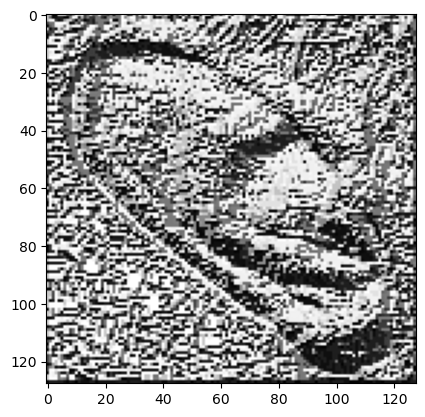

In [24]:
plt.imshow(skimage_lbp[0].reshape((128,128)), cmap='gray')



In [9]:
print(accuracy_score(skimage_lbp))
print(accuracy_score(skimage_lbp, "cityblock"))
print(accuracy_score(skimage_lbp, "cosine"))



0.223
0.261
0.114


In [29]:
skimage_uniform_lbp = [feature.local_binary_pattern(
    image.reshape((128,128)), L, R, method="uniform").flatten() for image in copy.deepcopy(IMAGES)]


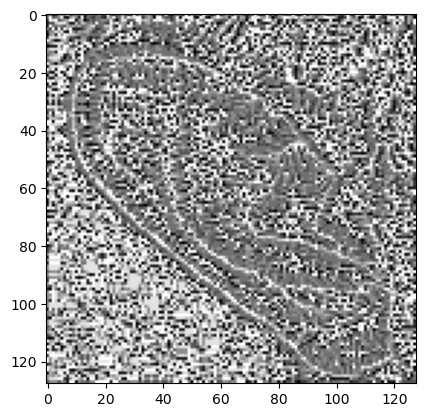

In [30]:
plt.imshow(skimage_uniform_lbp[0].reshape((128, 128)), cmap='gray')


In [31]:
print(accuracy_score(skimage_uniform_lbp))
print(accuracy_score(skimage_uniform_lbp, "cityblock"))
print(accuracy_score(skimage_uniform_lbp, "cosine"))


0.014
0.024
0.012


#### Simple LBP

In [13]:

def make_lbp_window(r, l):
    indices = [np.around(np.array(
        (r * np.sin(2*u*np.pi/l), r * np.cos(2*u*np.pi/l)))).astype(int) for u in range(l)]
    
    window = np.zeros((1 + np.ptp(indices), 1 + np.ptp(indices)))
    window_center = (window.shape[0] // 2, window.shape[1] // 2)
    window[window_center] = 1
    for x in indices:
        cords = x + window_center
        window[cords[0], cords[1]] = 1
    return window


In [14]:
lbp_footprint = make_lbp_window(R, L)


In [15]:

def simple_lbp(values):
    center = np.take(values, values.size // 2)
    values = np.delete(values, values.size // 2)
    values = np.array([(value - center >= 0) * 2 **
                      index for index, value in enumerate(values)])
    return np.sum(values)

lbp_images = [generic_filter(
        image, simple_lbp, footprint=lbp_footprint, mode="nearest").flatten()[::STEP] for image in copy.deepcopy(IMAGES)]


In [16]:
#plt.imshow(lbp_images[0].reshape((128,128)), cmap='gray')

In [17]:
print(accuracy_score(lbp_images))
print(accuracy_score(lbp_images, "cityblock"))
print(accuracy_score(lbp_images, "cosine"))

0.235
0.274
0.113


In [18]:
lbp_hist = make_histograms(copy.deepcopy(lbp_images), HIST_AREA, IMAGE_SIZE)

In [19]:
#plt.plot(lbp_hist[0])
#plt.show()

In [20]:
print(accuracy_score(lbp_hist))
print(accuracy_score(lbp_hist, "cityblock"))
print(accuracy_score(lbp_hist, "cosine"))

0.242
0.363
0.323


#### Uniform LBP

In [21]:
def uniform_calculation(values, center_value):
    u_1 = np.abs(int((values[-1] - center_value) >= 0) -
                 int((values[0] - center_value) >= 0))
    u_2 = np.sum(np.abs((values[1:] - center_value) >= 0).astype(int) -
                 ((values[:-1] - center_value) >= 0).astype(int))
    return (u_1 + u_2) <= 2


def uniform_lbp(values):
    center = np.take(values, values.size // 2)
    values = np.delete(values, values.size // 2)
    if uniform_calculation(values, center):
        return np.sum((values - center) >= 0)
    return L + 1


uniform_lbp_images = [generic_filter(
    image.reshape((128, 128)), uniform_lbp, footprint=lbp_footprint, mode="nearest").flatten()[::STEP] for image in copy.deepcopy(IMAGES)]


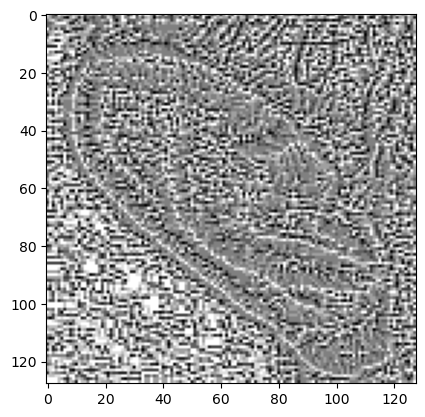

In [22]:
plt.imshow(uniform_lbp_images[0].reshape((128,128)), cmap='gray')

In [23]:
print(accuracy_score(uniform_lbp_images))
print(accuracy_score(uniform_lbp_images, "cityblock"))
print(accuracy_score(uniform_lbp_images, "cosine"))


0.028
0.028
0.028


In [24]:
uniform_lbp_hist = make_histograms(uniform_lbp_images, HIST_AREA, IMAGE_SIZE)

In [25]:
#plt.plot(uniform_lbp_hist[0])
#plt.show()

In [26]:
print(accuracy_score(uniform_lbp_hist))
print(accuracy_score(uniform_lbp_hist, "cityblock"))
print(accuracy_score(uniform_lbp_hist, "cosine"))

0.111
0.142
0.107
